In [2]:
from getdist import mcsamples, plots, chains
from getdist.mcsamples import MCSamplesError
import numpy as np
from subprocess import run
import os
from yaml import dump
from cobaya.yaml import yaml_load_file
from copy import deepcopy

In [107]:
class lkl_prof:
    
    def __init__(self, chains_dir, chain_file, prof_param, processes=6, R_minus_1_wanted=0.05, 
                 mcmc_chain_settings={'ignore_rows' : 0.3}, 
                 minimizer_settings={'minimize': {'method': 'bobyqa','covmat' : 'auto',}}, 
                 prof_incr=None, prof_min=None, prof_max=None
                ):
        self.chains_dir = chains_dir
        self.chain_file = chain_file
        
        self.processes = processes
        self.R_minus_1_wanted = R_minus_1_wanted
        self.mcmc_chain_settings = mcmc_chain_settings
        self.minimizer_settings = minimizer_settings
        
        self.prof_param = prof_param
        self.prof_incr = prof_incr
        self.prof_min = prof_min
        self.prof_max = prof_max
        
        os.chdir(self.chains_dir)
    
    def check_mcmc_chains(self):
        """
        Check if mcmc chains chains exist 
        
        :return: True if files found, else False 
        """
        try:
            self.mcmc_chains = mcsamples.loadMCSamples(self.chains_dir+self.chain_file, settings=self.mcmc_chain_settings)
            return True
        except OSError:
            return False 
        
    def run_mcmc(self, resume=False):
        self.mcmc_yaml = yaml_load_file(self.chains_dir+self.chain_file+'.yaml')
        try:
            self.mcmc_yaml['sampler']['mcmc']['Rminus1_stop'] = self.R_minus_1_wanted
        except KeyError:
            print("Error: Input yaml not set up correctly for an mcmc run. Please ensure the sampler 'mcmc' is correctly set. ")
            raise KeyError
        if self.mcmc_yaml['output'].count('/') > 1:
            print("Error: For correct functioning of the code, please have the input .yaml file in the same directory as the output chains. Currently, output is: "+self.mcmc_yaml['output'])
            raise OSError
        if resume==False:
            run("mpirun -np "+str(self.processes)+" cobaya-run "+self.chain_file+".yaml", shell=True)
        else:
            run("mpirun -np "+str(self.processes)+" cobaya-run "+self.chain_file+".yaml -r", shell=True)
        
    def check_mcmc_convergence(self, mcmc_chains=None):
        """
        Check if MCMC converged 
        
        :mcmc_chains: getdist MCSamples instance 
        
        :return: True if MCMC chains have converged to the desired R-1, default is R-1=0.05. Else False 
        """
        if mcmc_chains==None:
            mcmc_chains=self.mcmc_chains
            
        current_R_minus_1 = mcmc_chains.getGelmanRubin()
        if current_R_minus_1 < self.R_minus_1_wanted:
            print("Chains converged sufficiently. Current R-1 = {:.3f} satisfies R-1 wanted = {:.3f}. \nMove on to checking minimum.".format(current_R_minus_1,self.R_minus_1_wanted))
            return True
        else: 
            print("Chains not converged. Current R-1 = {:.3f} while R-1 wanted = {:.3f}. \nResuming MCMC. ".format(current_R_minus_1,self.R_minus_1_wanted))
            return False 

    def check_global_min(self, mcmc_chains=None):
        """
        Check if minimizer was run
        
        :mcmc_chains: getdist MCSamples instance 
        
        :return: True if global minimum was run and relevant files are accesible. Else False 
        """
        if mcmc_chains==None:
            mcmc_chains=self.mcmc_chains
            
        try:
            mcmc_chains.getParamBestFitDict()
            min_yaml = yaml_load_file(self.chains_dir+self.chain_file+'.minimize.updated.yaml')
            print("check_global_min: Found previously run MCMC chains and global minimizer. ")
            return True
        except MCSamplesError:
            print("check_global_min: Need to first run a minimizer on the full MCMC chains before beginning 1d profile lkl code.")
            return False 
        except FileNotFoundError:
            print("check_global_min: Found best-fit but not the file "+self.chains_dir+self.chain_file+".minimize.updated.yaml. Something has gone wrong. ")
            return FileNotFoundError    
        
        
    def pn_ext(self, extension):
        """
        Prefix the file extension string input with the sign of the profile lkl parameter increment to track files correctly. 
        
        :extension: A string of the file name extension without the sign of the prof_parameter 
        :return: String of extension prefixed with the sign of the increment of profile lkl parameter 
        """
        if len(extension)>0:
            if self.prof_incr > 0:
                extension = '_p'+extension
            if self.prof_incr < 0:
                extension = '_n'+extension
        return extension
        
    def read_minimum(self, extension='_lkl_prof'):
        """
        Read minimum file and save parameter names list, parameter values list and MLs dictionary 
        
        :extension: The extension of the life type being read in. Leave this as is, the rest of the code assumes the same naming conventions. 
        
        :return: List of parameter names, list of parameter ML values, dictionary of {'param_names': param_ML_value}
        """
        extension=self.pn_ext(extension)
        
        param_ML, param_names = np.loadtxt(self.chains_dir + self.chain_file + extension + '.minimum', skiprows=3, usecols = (1,2), dtype=str, unpack=True)
        param_ML = param_ML.astype(float)
        
        with open(self.chains_dir + self.chain_file + extension + '.minimum') as min_file:
            loglkl_and_chi = [next(min_file) for x in range(2)] # reading in the first two lines separately for -log(lkl) and chi^2
        for line in loglkl_and_chi:
            param_names = np.append(param_names, line.split("=")[0])
            param_ML = np.append(param_ML, float(line.split("=")[1]))
        MLs = dict(zip(param_names, param_ML))
        
        self.param_names = param_names
        self.MLs = MLs
        
        return param_names, param_ML, MLs
    
    def read_lkl_output(self, extension='_lkl_profile.txt', loc=-1):
        """
        Read (default = last) line of lkl prof output file into list
        
        :extension: Leave this alone, thank you. 
        :loc: integer location of line in file to read. Default is last line 
        
        :return: List of parameters
        """

        extension=self.pn_ext(extension)

        lkl_prof_table = np.loadtxt(self.chains_dir + self.chain_file + extension)
        try:
            lkl_prof_table.shape[1] # check that lkl_prof_table has multiple rows
            lkl_prof_table = lkl_prof_table[loc, :]
        except IndexError:
            pass
        return lkl_prof_table
    
    def write_MLs(self, MLs=None, extension='_lkl_profile.txt'):
        """
        Write params from MLs dict into txt file in append mode
        Note that to write, we use self.param_order, not self.param_names. 
        This is because the global param_names list is the one that has the correct order. 
        
        :extension: Leave it alone, thank you.
        
        :return: new length of the saved lkl profile table
        
        """
        if MLs == None:
            MLs = self.MLs
        extension=self.pn_ext(extension)
        
        with open(self.chains_dir + self.chain_file + extension, 'a') as lkl_txt:
            for param in self.param_order:
                lkl_txt.write("\t %s" % str(MLs[param]))
            lkl_txt.write("\n")
        lkl_prof_table = np.loadtxt(self.chains_dir + self.chain_file + extension)
        return lkl_prof_table.shape
    
    
    def match_param_names(self, param_names, extension='_lkl_profile.txt'):
        """
        Check that param names match in target file and MLs dictionary
        
        :param_names: List of param_names to check against the file 
        :extension: Leave it alone, thank you. 
        
        :return: True if param_names match, else False
        """
        
        extension=self.pn_ext(extension)
        
        with open(self.chains_dir + self.chain_file + extension, 'r') as lkl_txt:
            params_recorded = lkl_txt.readline()
        # define the expected first row of this file
        expected_string = '#'
        for param in param_names:
            expected_string += "\t %s" % param
        expected_string += "\n"
        if expected_string == params_recorded:
            print("match_param_names: Found existing file with correct name and parameters / parameter sequence. Will append to it. \n" 
                     + self.chains_dir + self.chain_file + extension)
            return True
        else:
            print("match_param_names: Error: existing file found at " + self.chains_dir + self.chain_file + extension 
                 + "\n but parameters / parameter sequence does not match expected.")
            print("--> parameters found: \n" + params_recorded)
            print("--> parameters expected: \n" + expected_string)
            raise FileExistsError
            return False
    
    def match_param_line(self, MLs, param_names=None, extension='_lkl_profile.txt', loc=-1):
        """
        Check if specified (default: last) location in lkl_prof output file matches current MLs
        
        :param_names: list of parameter names in the same order as that printed in the file. 
                        This is usually the global param_order list. 
        :MLs: dictionary of {'param_name': ML_value }
        :extension: Leave it alone, thank you. 
        :loc: integer location of row in file to check, default is the last line
        
        :return: True if match, else False 
        """
        
        extension=self.pn_ext(extension)
        
        if param_names==None:
            param_names=self.param_order

        lkl_prof_table = np.loadtxt(self.chains_dir + self.chain_file + extension)
        if lkl_prof_table.size==0:
            print("match_param_line: File empty ")
            return False
        else: 
            try:
                lkl_prof_table.shape[1] # check that lkl_prof_table has multiple rows
                if False in [lkl_prof_table[loc, np.where(param_names == param)] == MLs[param] for param in param_names]:
                    return False
                else:
                    return True 
            except IndexError:
                print("match_param_line: Only one entry in file, checking that entry ")
                if False in [lkl_prof_table[np.where(param_names == param)] == MLs[param] for param in param_names]:
                    return False 
                else:
                    return True               


    def increment_update_yaml(self, MLs, lkl_pro_yaml, yaml_ext = '_lkl_prof'):
        """
        Update yaml info to next increment 
        
        
        :MLs: dictionary of {'param_name': ML_value }
        :lkl_pro_yaml: dictionary of yaml info for running lkl profile incremental minimizer 
        :yaml_ext: Leave it alone. 
        
        :return: dictionary for yaml info of profile lkl parameter, including incremented value and latex info
        """
        yaml_ext=self.pn_ext(yaml_ext)
        
        # update profile lkl param 
        latex_info = lkl_pro_yaml['params'][self.prof_param]['latex']
        lkl_pro_yaml['params'][self.prof_param] = {'value': MLs[self.prof_param]+self.prof_incr, 'latex': latex_info}
        lkl_pro_yaml['output'] = self.chain_file + yaml_ext
        # update all other independent parameters 
        for param in lkl_pro_yaml['params']:
            if 'prior' in lkl_pro_yaml['params'][param]:
                lkl_pro_yaml['params'][param]['ref'] = MLs[param]
        # dump yaml to file for running 
        with open(self.chains_dir+self.chain_file+yaml_ext+'.minimize.input.yaml', 'w') as yaml_file:
            dump(lkl_pro_yaml, yaml_file, default_flow_style=False)    
        return lkl_pro_yaml['params'][prof_param]
    
    def run_minimizer(self, yaml_ext='_lkl_prof', debug=False):
        """
        Run minimizer 
        For the parameter we want to vary, remove all but latex and value. 
        The latex is as before from the MCMC yaml file. 
        The value is ML $\pm$ increment. 
        
        :yaml_ext: Leave it alone. 
        :debug: Do you want Cobaya debug output (it's a LOT)
        
        :return: True
        """
        yaml_ext=self.pn_ext(yaml_ext)

        if debug==True:
            run("mpirun -np "+str(self.processes)+" cobaya-run "+self.chain_file+yaml_ext+".minimize.input.yaml -f -d", shell=True)
        else:
            run("mpirun -np "+str(self.processes)+" cobaya-run "+self.chain_file+yaml_ext+".minimize.input.yaml -f", shell=True)   
        return True
    
    def full_lkl_prof_array(self):
        """
        Combine positive and negative increment files into one array 
        
        :return: full likelihood profile array 
        """
        try:
            all_MLs_p = np.loadtxt(self.chains_dir+self.chain_file+'_p_lkl_profile.txt')
            pos_file = True
        except OSError:
            pos_file = False
        try:
            all_MLs_n = np.loadtxt(self.chains_dir+self.chain_file+'_n_lkl_profile.txt')
            if pos_file==True:
                all_MLs = np.concatenate( (np.flip(all_MLs_n, 0),all_MLs_p) )
            else:
                all_MLs = np.flip(all_MLs_n, 0)
        except OSError:
            all_MLs = all_MLs_p

        return all_MLs

    def full_lkl_prof_dict(self):
        """
        Combine positive and negative increment files into one dictionary with 
        keys = param names 
        values = 1D array of profile likelihood values 
        
        :return: full likelihood profile dictionary 
        """
        full_prof_dict = {}
        full_lkl_prof_array = self.full_lkl_prof_array()

        for param_num in range(len(self.param_order)):
            full_prof_dict[self.param_order[param_num]] = full_lkl_prof_array[:,param_num]

        return full_prof_dict

    def sum_params(self, params_to_sum):
        """
        Sum list of params and return array of summed params.
        Useful for adding up chi^2's post profile lkl run 
        
        :params_to_sum: list of parameter names that you want to sum. 
        
        :return: array of summed parameters 
        """
        prof_lkl = self.full_lkl_prof_dict()

        param_vectors = [prof_lkl[param] for param in params_to_sum]
        param_stack = np.stack(param_vectors, axis=0)
        summed_params = param_stack.sum(axis=0)

        return summed_params
    
    def mcmc(self):
        """
        Check MCMC and run if needed 
        """
        if not self.check_mcmc_chains():
            self.run_mcmc()
        elif not self.check_mcmc_convergence():
            self.run_mcmc(resume=True)
    
    def global_min(self):
        """
        Check global minizer, run if needed, then write if not already written 
        """
        if not self.check_global_min():
            self.min_yaml = yaml_load_file(self.chains_dir+self.chain_file+'.input.yaml')
            self.min_yaml['sampler'] = self.minimizer_settings

            with open(self.chains_dir + self.chain_file + '.minimize.input.yaml', 'w') as yaml_file:
                dump(self.min_yaml, yaml_file, default_flow_style=False)

            self.run_minimizer(yaml_ext='', debug=True) 
            
        param_names, param_ML, MLs = self.read_minimum(extension='')
        self.global_ML = deepcopy(MLs)
        self.param_order = param_names
        
        try:
            self.match_param_names(self.param_order)
        except FileNotFoundError:
            extension = '_lkl_profile.txt'
            print("File not found. Starting a new file now: " + self.chains_dir + self.chain_file + self.pn_ext(extension) + '\n')
            with open(self.chains_dir + self.chain_file + self.pn_ext(extension), 'w') as lkl_txt:
                lkl_txt.write("#")
                for param_recorded in self.param_order:
                    lkl_txt.write("\t %s" % param_recorded)
                lkl_txt.write("\n")
                
        extension = '_lkl_profile.txt'
        lkl_prof_table = np.loadtxt(self.chains_dir + self.chain_file + self.pn_ext(extension))

        if lkl_prof_table.shape!=(0,):
            if not self.match_param_line(self.global_ML, loc=0):
                print("Something went wrong. The first line of the lkl_profile.txt file which should be global ML does not match the global ML in file \n"
                     +self.chains_dir + self.chain_file + '.minimum')
                raise FileExistsError
        else: 
            self.write_MLs()
            
    def init_lkl_prof(self):

        extension = '_lkl_prof'
        try:
            lkl_pro_yaml = yaml_load_file(self.chains_dir+self.chain_file+self.pn_ext(extension)+'.minimize.input.yaml')
        except FileNotFoundError:
            run("cp "+self.chains_dir+self.chain_file+'.minimize.updated.yaml'+" "
                    +self.chains_dir+self.chain_file+self.pn_ext(extension)+'.minimize.input.yaml', shell=True)
            lkl_pro_yaml = yaml_load_file(self.chains_dir+self.chain_file+self.pn_ext(extension)+'.minimize.input.yaml')
        lkl_pro_yaml['sampler'] = self.minimizer_settings
        lkl_pro_yaml['sampler']['minimize']['covmat'] = self.chains_dir+self.chain_file+'.covmat'

        param_ML = self.read_lkl_output()
        test.MLs = dict(zip(self.param_names, param_ML))

# Testing code below

In [110]:
test = lkl_prof('/home2/karwal/lkl_prof/lcdm_tests_output/', 'lcdm_cmb_bao_sne_', 'H0')

test.prof_incr = -0.1
test.prof_max = 70.
test.processes = 1

### Set up for prof lkl

In [111]:
test.mcmc()

test.global_min()

Chains converged sufficiently. Current R-1 = 0.030 satisfies R-1 wanted = 0.050. 
Move on to checking minimum.
check_global_min: Found previously run MCMC chains and global minimizer. 
match_param_names: Found existing file with correct name and parameters / parameter sequence. Will append to it. 
/home2/karwal/lkl_prof/lcdm_tests_output/lcdm_cmb_bao_sne__n_lkl_profile.txt


## Likelihood profile

### Initialise profile lkl

In [114]:
test.init_lkl_prof()

### Run loop over increments of profile lkl param

In [78]:
time_extension = '_time_stamps.txt'
with open(test.chains_dir + test.chain_file + test.pn_ext(time_extension), 'w') as lkl_txt:
    lkl_txt.write("#")
    lkl_txt.write(" %s \t step_size \t minimizer_time " % test.prof_param)
    lkl_txt.write("\n")

In [79]:
extension = '_lkl_prof'
extension = test.pn_ext(extension)
while ((MLs[test.prof_param] < test.prof_max) and (MLs[test.prof_param] > test.prof_min)):
    last_entry_matches_current_params = test.match_param_line(MLs)
    if last_entry_matches_current_params:
        run('rm '+test.chains_dir + test.chain_file + extension + '.minimum*', shell=True)
        minimum_successfully_run_and_saved = True
    else:
        try:
            param_names, param_ML, MLs = test.read_minimum()
            test.write_MLs(MLs)
            run('rm '+test.chains_dir + test.chain_file + extension + '.minimum*', shell=True)
            minimum_successfully_run_and_saved = True 
            print("-----> Minimizer run successfully for "+test.prof_param+" = "+str(MLs[test.prof_param]))
        except OSError:
            minimum_successfully_run_and_saved = False
            print("-----> Minimizer not run for "+test.prof_param+" = "+str(MLs[test.prof_param]))
            print("       Rerunning this point")

    if minimum_successfully_run_and_saved:
        test.increment_update_yaml(MLs, lkl_pro_yaml)
        run('rm '+test.chains_dir + test.chain_file + extension + '.minimize.updated.yaml', shell=True)
    
    time_start = time()
    
    test.run_minimizer()
    
    time_end = time()
    time_taken = time_end - time_start
    
    with open(test.chains_dir + test.chain_file + time_extension, 'a') as lkl_txt:
        lkl_txt.write("{:.4g} \t {:.2g} \t {:.2f} \n".format(lkl_pro_yaml['params'][test.prof_param]['value'], 
                                                             test.prof_incr, time_taken))
    print("       Time taken for minimizer = {:.2f}".format(time_taken))
        
    param_names, param_ML, MLs = test.read_minimum()
    
# #     TK : I AM RUNNING A TEST BY DOUBLING THE INCREMENT PER RUN. COMMENT OUT NEXT LINE BEFORE ACTUAL RUNS !!! 
#     prof_incr *= 2.
# #     PROFILE INCREMENT DOUBLED ABOVE !!!!! 

In [80]:
param_names, param_ML, MLs = test.read_minimum()
test.write_MLs(MLs)

(9, 82)

## Analysis functions 

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
chis = test.sum_params(['chi2__CMB', 'chi2__SN', 'chi2__BAO'])
lkl_prof_param = test.full_lkl_prof_dict()[test.prof_param]

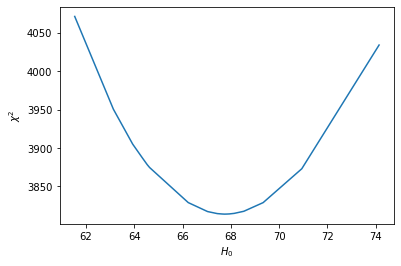

In [76]:
plt.plot( lkl_prof_param , chis )
plt.ylabel(r'$\chi^2$')
plt.xlabel(r'$'+lkl_pro_yaml['params'][test.prof_param]['latex']+'$')
plt.show()

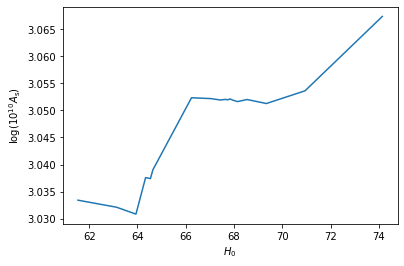

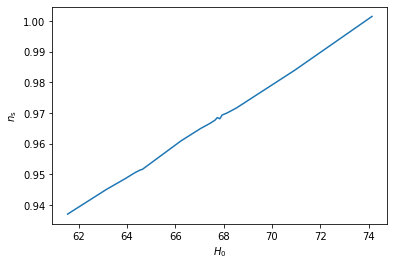

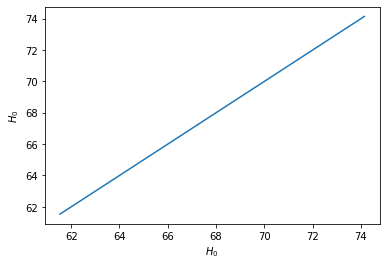

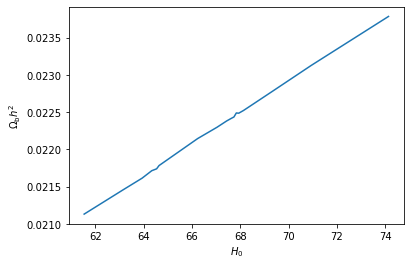

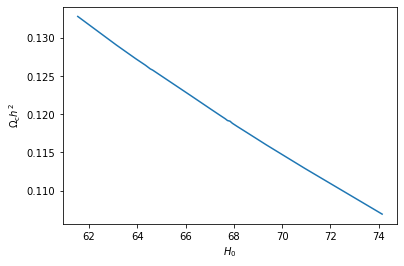

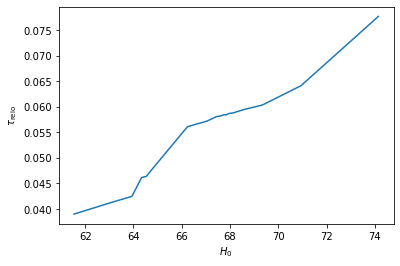

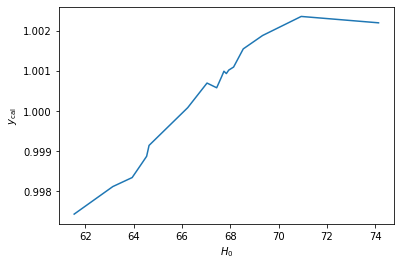

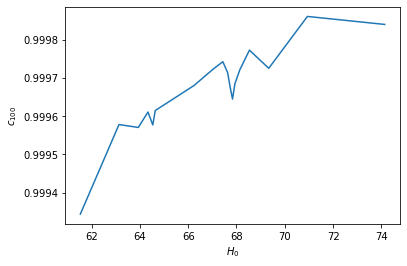

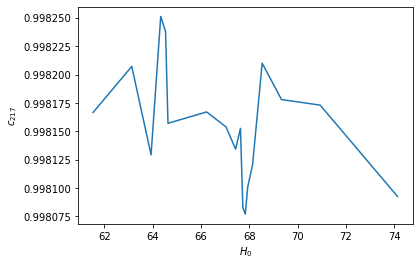

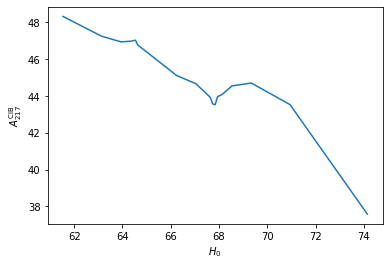

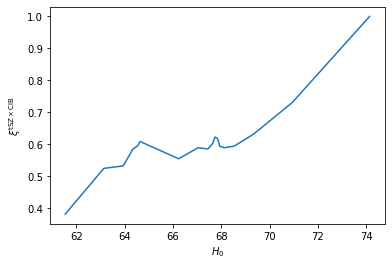

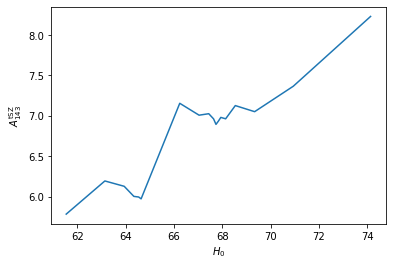

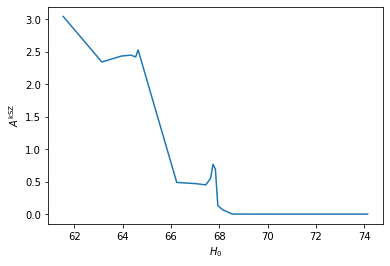

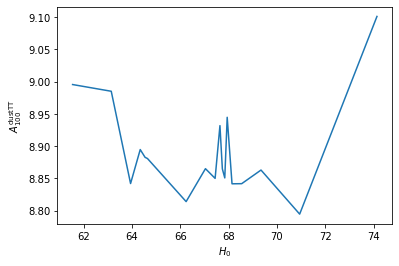

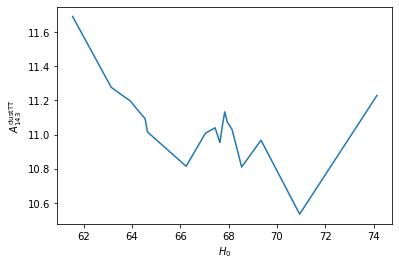

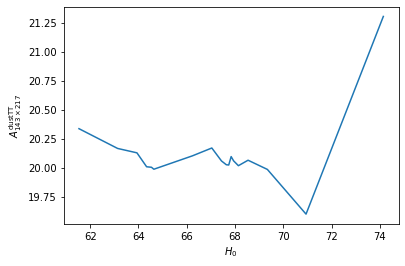

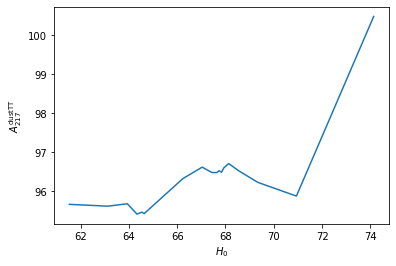

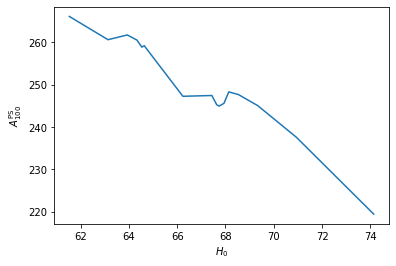

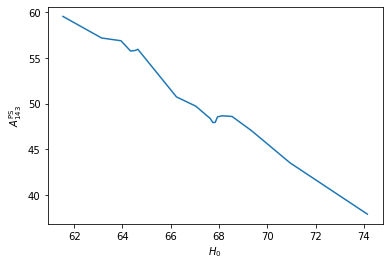

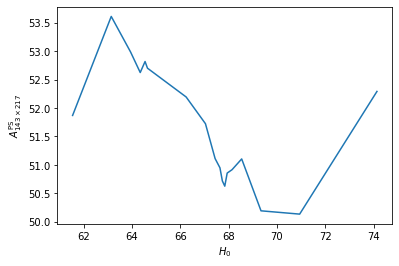

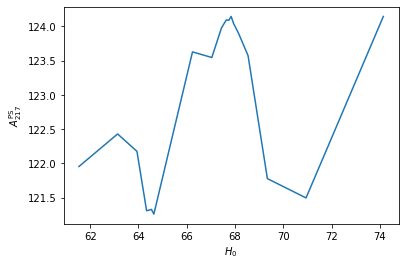

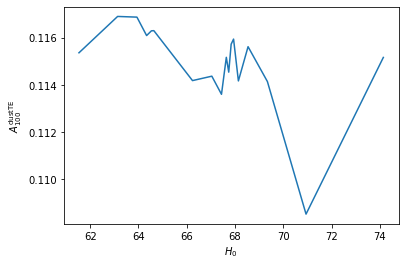

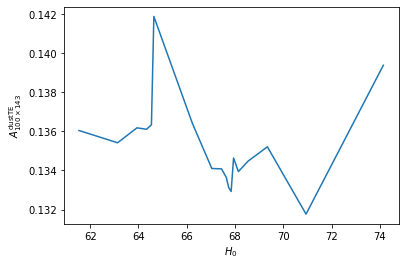

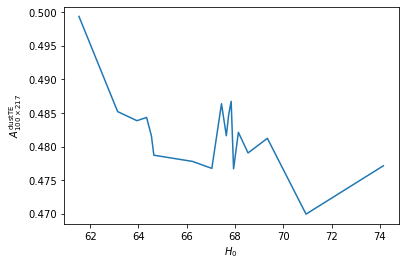

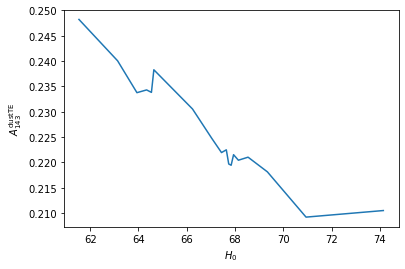

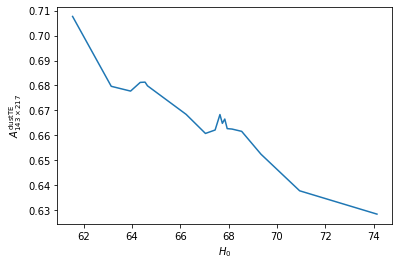

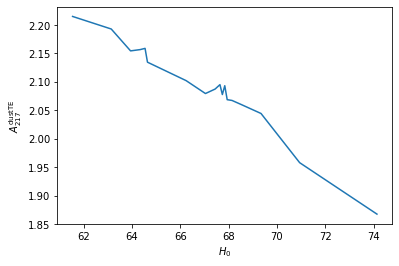

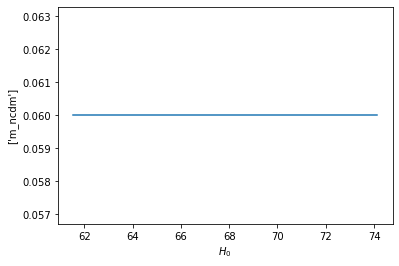

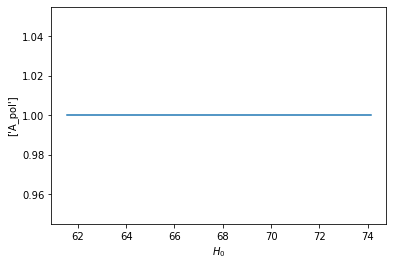

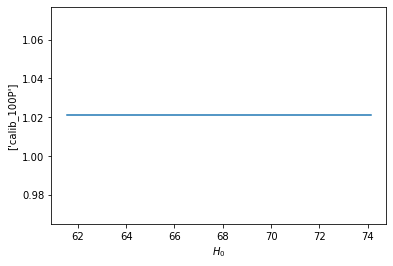

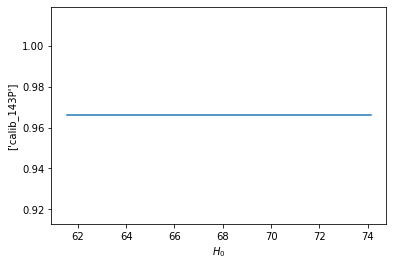

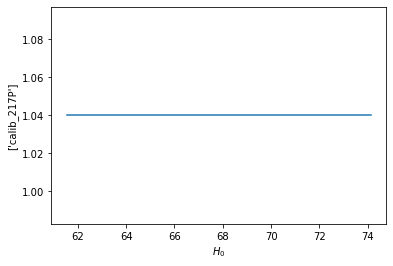

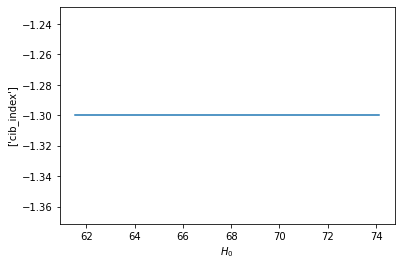

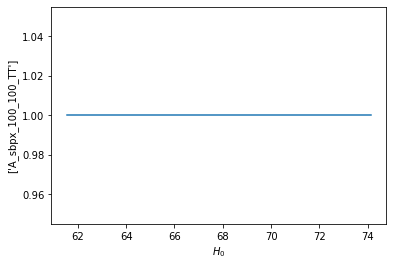

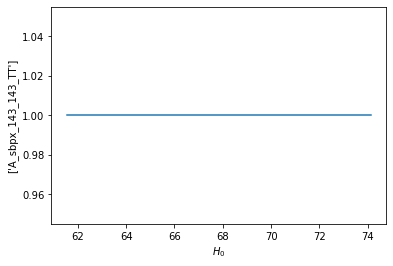

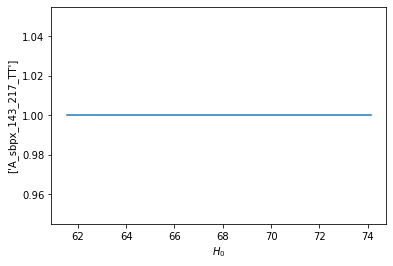

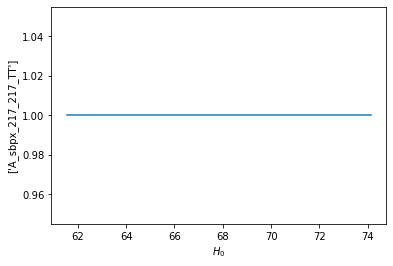

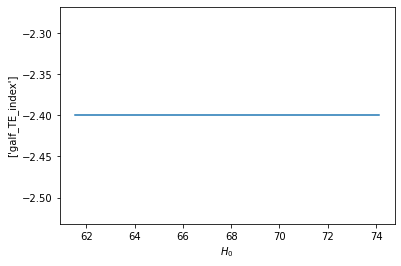

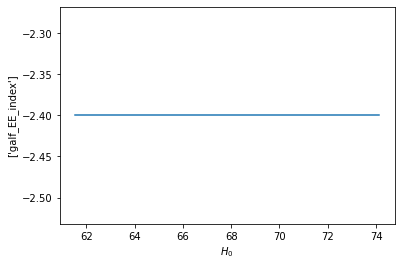

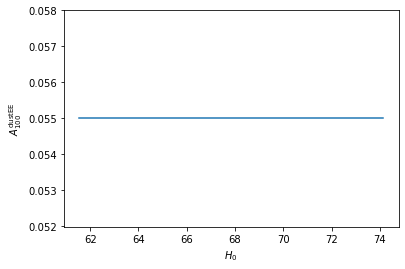

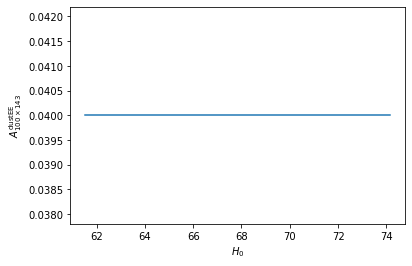

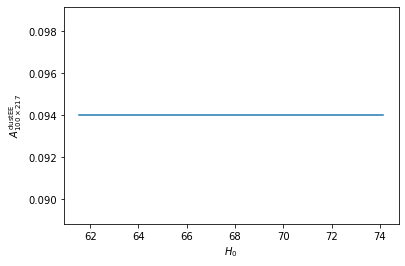

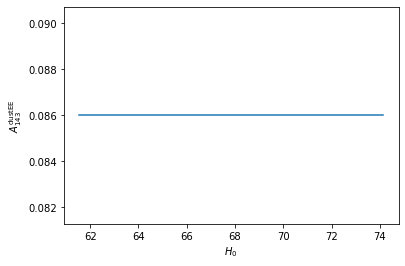

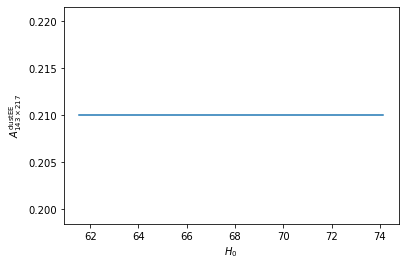

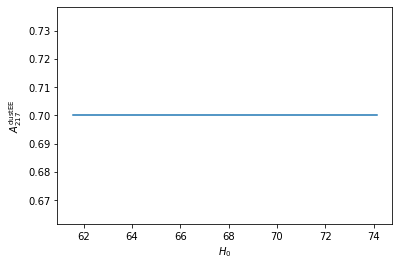

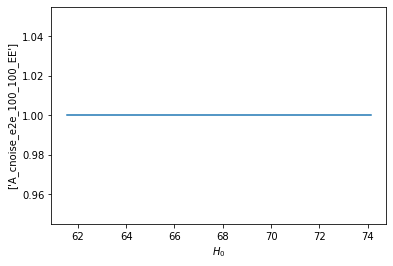

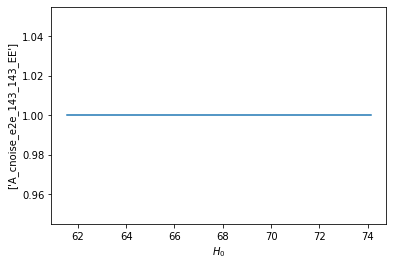

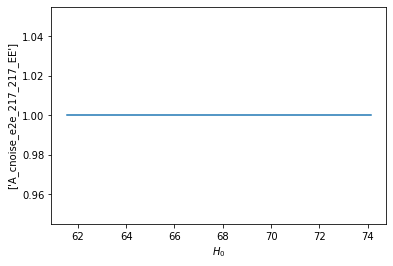

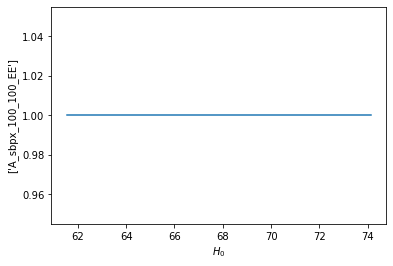

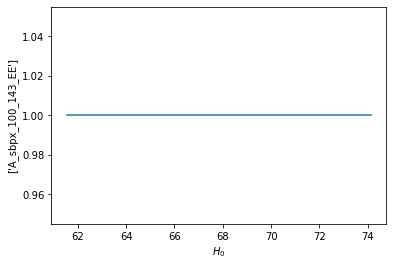

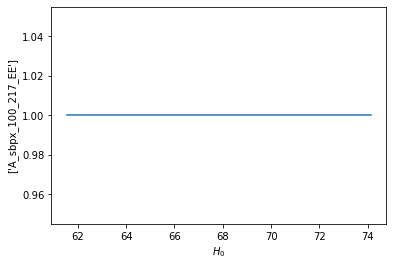

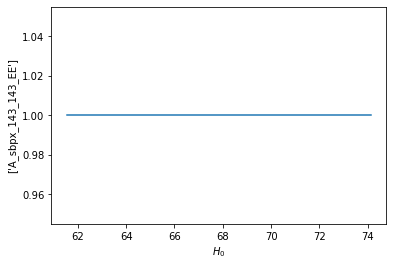

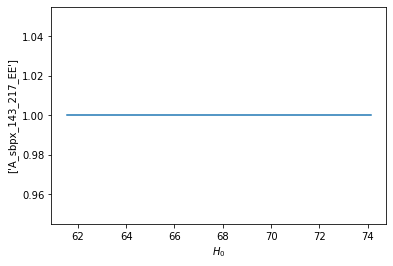

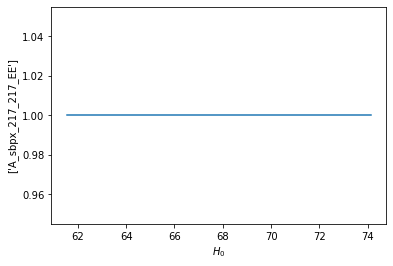

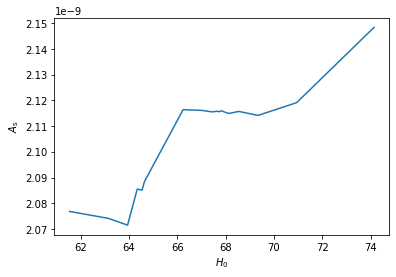

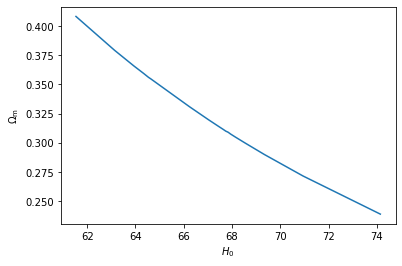

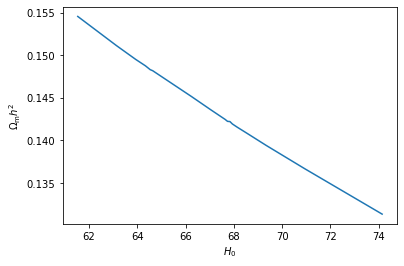

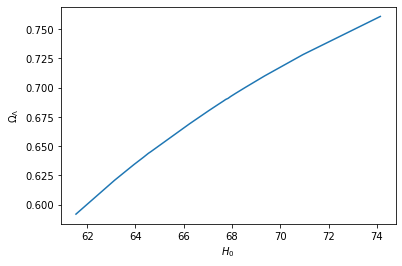

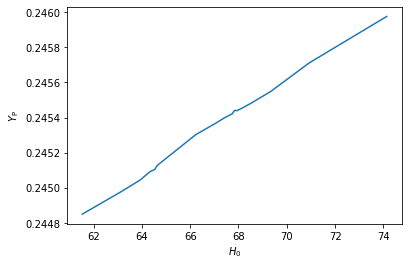

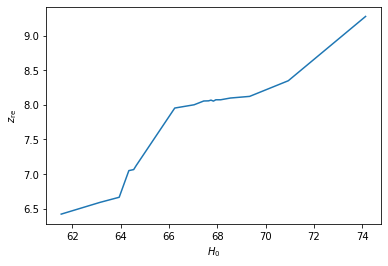

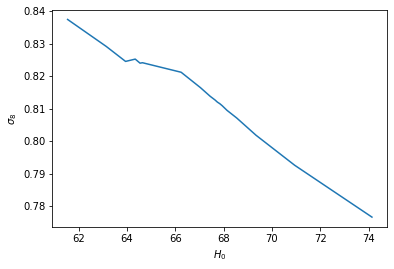

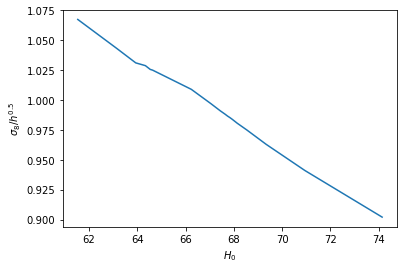

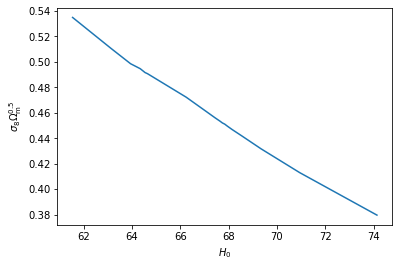

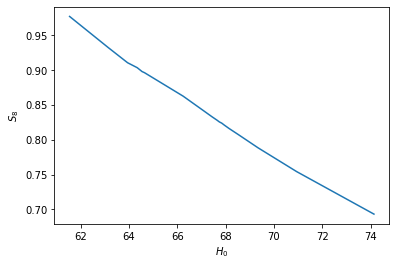

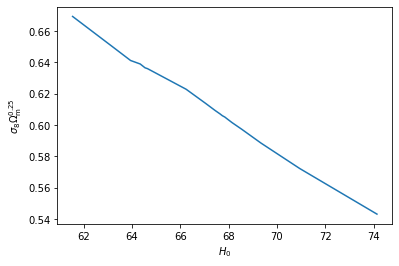

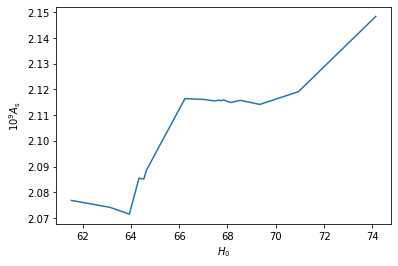

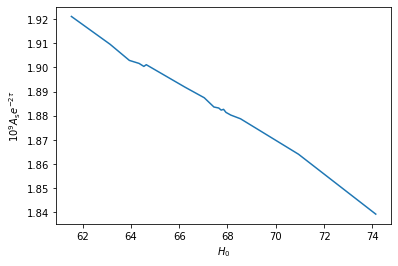

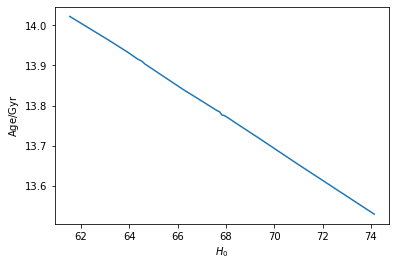

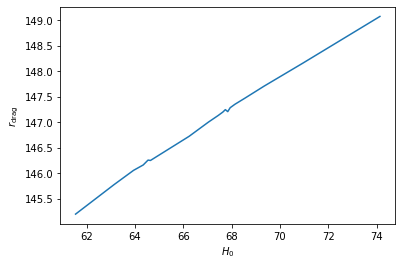

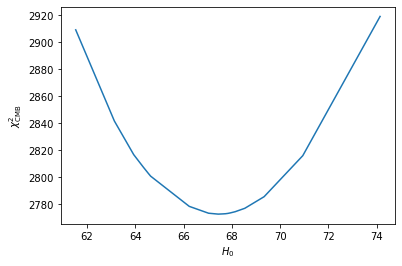

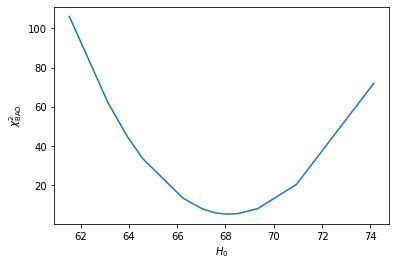

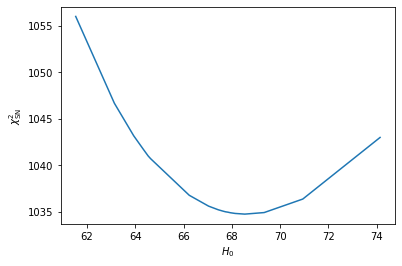

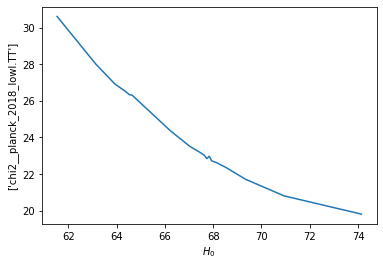

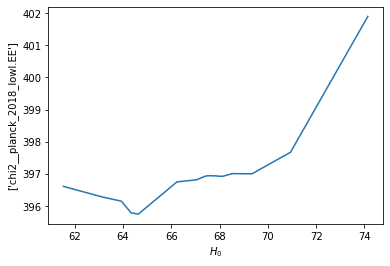

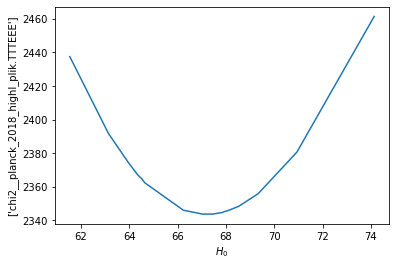

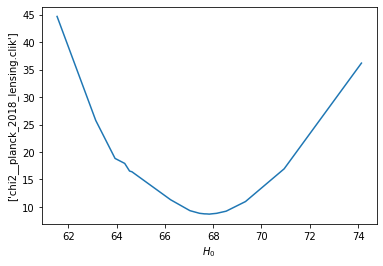

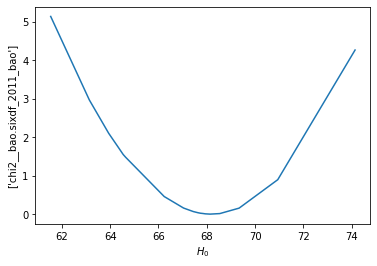

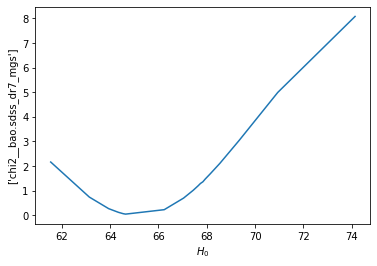

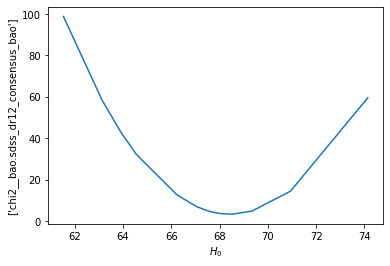

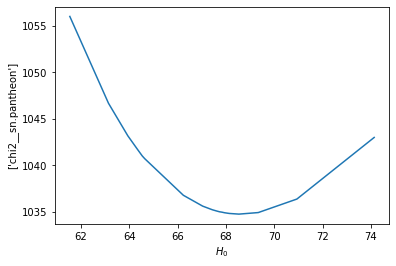

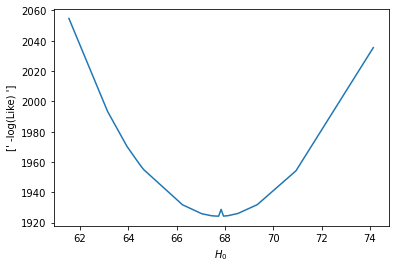

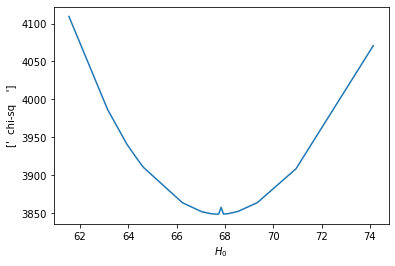

In [78]:
prof_lkl_output = test.full_lkl_prof_dict()

for param in test.param_order:
    plt.plot( prof_lkl_output[test.prof_param], prof_lkl_output[param] )
    try:
        plt.ylabel(r'$'+lkl_pro_yaml['params'][param]['latex']+'$')
    except KeyError:
        plt.ylabel([param])
    plt.xlabel(r'$'+lkl_pro_yaml['params'][test.prof_param]['latex']+'$')
#     plt.ylabel(param)
#     plt.xlabel(test.prof_param)
    plt.show()

In [82]:
test.full_lkl_prof_dict()

{'logA': array([3.03343387, 3.03213525, 3.0308661 , 3.03759555, 3.037415  ,
        3.03901356, 3.05230597, 3.05215502, 3.0518916 , 3.0520079 ,
        3.05193137, 3.05209112, 3.05209112, 3.0518862 , 3.05160043,
        3.05198461, 3.05124532, 3.05358808, 3.06729226]),
 'n_s': array([0.93699838, 0.94502087, 0.94864216, 0.95058352, 0.95137679,
        0.95163088, 0.96092961, 0.96491146, 0.96663923, 0.96765269,
        0.96850873, 0.96811547, 0.96811547, 0.96935424, 0.97000216,
        0.97169042, 0.97577939, 0.98394497, 1.00151395]),
 'H0': array([61.53770587, 63.13770587, 63.93770587, 64.33770587, 64.53770587,
        64.63770587, 66.23770587, 67.03770587, 67.43770587, 67.63770587,
        67.73770587, 67.83770587, 67.83770587, 67.93770587, 68.13770587,
        68.53770587, 69.33770587, 70.93770587, 74.13770587]),
 'omega_b': array([0.02113125, 0.02145486, 0.02161404, 0.02171422, 0.02173929,
        0.02178296, 0.02214567, 0.02229726, 0.02238202, 0.02241822,
        0.02243495, 0.02248

In [17]:
a = [0,1,2,3,4]

np.flip(a, 0)

array([4, 3, 2, 1, 0])